# Разработка A/B-тестирования и анализ результатов

Компания разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Таблицы:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).




### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
Рассмотрим исторические данные приложения:


In [1]:
import pandas as pd

In [2]:
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.

- Выведем данные из таблицы `sessions_history` для пользователя с наибольшим количеством сессий.




In [3]:
sessions_history_gp = sessions_history.groupby('user_id')['session_id'].nunique().reset_index().sort_values(by= 'session_id', ascending = False)
sessions_history_gp.head(10)

,user_id,session_id
8948,10E0DEFC1ABDBBE0,10
55627,6A73CB5566BB494D,10
72346,8A60431A825D035B,9
109383,D11541BAC141FB94,9
47956,5BCFE7C4DCC148E9,9
22611,2AF89E9BC4D631A3,9
29354,37E4825C6A22A519,9
53434,66374F4203EFEDA7,9
16936,1FE6E098C8A7E9A3,9
84534,A1E1B4CCA664587C,9


In [4]:
display(sessions_history[sessions_history['user_id'].isin(sessions_history_gp.head(2)['user_id'])].sort_values(by=['user_id',
                                                                                                                  'session_number']))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


При наличии нескольких сессий у одного пользователя, каждой сессии присваивается порядковый номер в зависимости от даты и времени этой сессии, количество просматриваемых страниц в каждой сессии может различаться. Также стоит отметить, что, начиная с определенной сессии, у пользователя может поменяться статус регистрации в приложении.

#### 1.3. Анализ числа регистраций
Визуализируем, как менялось число регистраций в приложении за время его существования.


In [5]:
session_date_gp = sessions_history.groupby('session_date').agg({'user_id': 'nunique', 'registration_flag': 'sum'}).reset_index()
session_date_gp['registration_share'] = session_date_gp['registration_flag'] / session_date_gp['user_id']
session_date_gp.head()

,session_date,user_id,registration_flag,registration_share
0,2025-08-11,3919,169,0.043123
1,2025-08-12,6056,336,0.055482
2,2025-08-13,8489,464,0.054659
3,2025-08-14,10321,625,0.060556
4,2025-08-15,14065,840,0.059723


In [6]:
import matplotlib.pyplot as plt

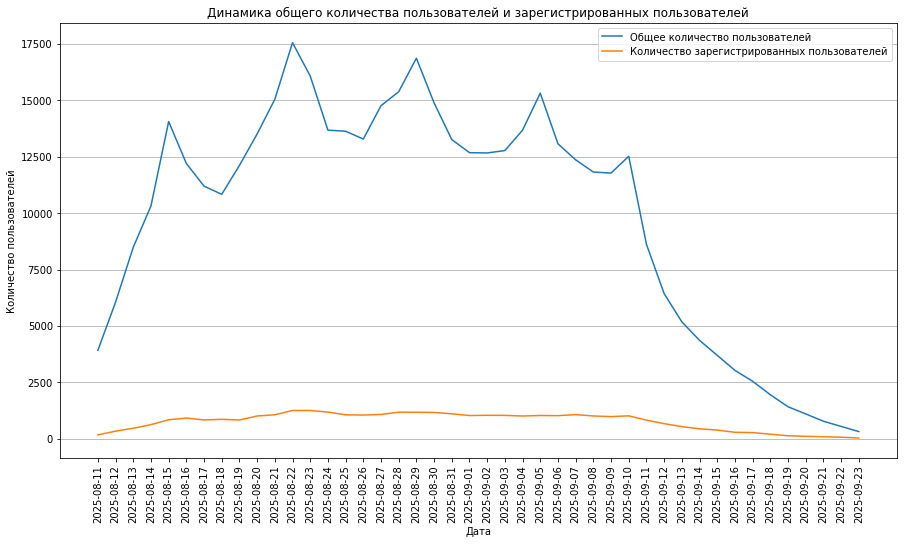

In [7]:
plt.figure(figsize=(15, 8))

plt.plot(session_date_gp['session_date'], session_date_gp['user_id'], label ='Общее количество пользователей')
plt.plot(session_date_gp['session_date'], session_date_gp['registration_flag'], label ='Количество зарегистрированных пользователей')

plt.xlabel("Дата")
plt.xticks(rotation=90)

plt.ylabel("Количество пользователей")
plt.legend()
plt.grid(axis='y')
plt.title('Динамика общего количества пользователей и зарегистрированных пользователей')

plt.show()

- Количество зарегистрированных пользователей значительно меньше общего количества;
- Динамика количества общих пользователей довольно волатильна с явными пиками активности в определенные даты;
- К концу наблюдаемого периода количество пользователей начинает стремиться к нулю.

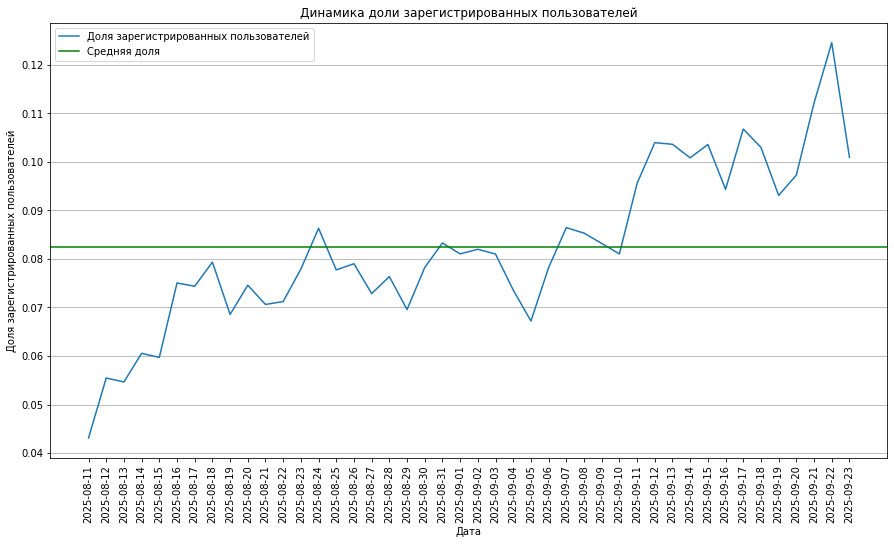

0.08243688414765839

In [8]:
plt.figure(figsize=(15, 8))

plt.plot(session_date_gp['session_date'], session_date_gp['registration_share'], label ='Доля зарегистрированных пользователей')

plt.xlabel("Дата")
plt.xticks(rotation=90)

mean_value = session_date_gp['registration_share'].mean()
plt.axhline(y=mean_value, color='g', label='Средняя доля')

plt.ylabel("Доля зарегистрированных пользователей")
plt.legend()
plt.grid(axis='y')
plt.title('Динамика доли зарегистрированных пользователей')

plt.show()

display(mean_value)

- Можно также отметить довольно выраженную волатильность наблюдений;
- Доля зарегистрированных пользователей не превышала 13%, в среднем она находилась на уровне 8.2%
- Однако заметен общий тренд на постепенное увеличение доли зарегистрированных пользователей.

#### 1.4. Анализ числа просмотренных страниц

- Найдем количество сессий для каждого значения количества просмотренных страниц и Построим столбчатую диаграмму.

In [9]:
page_counter_gp = sessions_history.groupby('page_counter')['session_id'].nunique().reset_index().sort_values(by= 'page_counter')
page_counter_gp

,page_counter,session_id
0,1,29160
1,2,105536
2,3,166690
3,4,105569
4,5,26288
5,6,2589
6,7,92


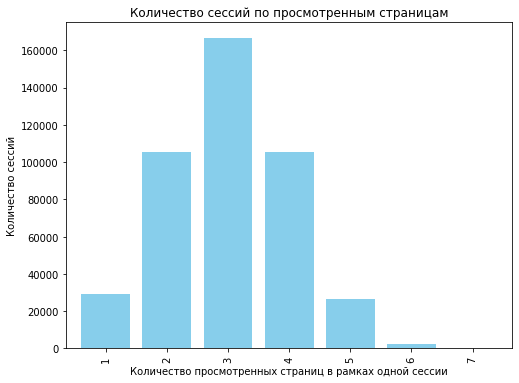

In [10]:
page_counter_gp.plot(kind='bar',
x= 'page_counter',                     
title='Количество сессий по просмотренным страницам',
legend=False,
ylabel='Количество сессий',
xlabel='Количество просмотренных страниц в рамках одной сессии',
color='skyblue',
width=0.8,                     
figsize = (8, 6))

plt.show()

- В 166,7 тыс. сессиях было просмотрено по 3 страницы;
- Наибольшее количество страниц за сессию (7) было просмотрено в 92 сессиях.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- Создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий ко всем сессиям по дням за весь период наблюдения.

In [11]:
sessions_history['good_session'] = 0
sessions_history.loc[sessions_history['page_counter'] > 3, 'good_session'] = 1
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [12]:
good_session_gp = sessions_history.groupby('session_date').agg({'session_id': 'nunique', 'good_session': 'sum'}).reset_index()
good_session_gp['good_session_share'] = good_session_gp['good_session'] / good_session_gp['session_id']
good_session_gp.head()

,session_date,session_id,good_session,good_session_share
0,2025-08-11,3919,1226,0.312835
1,2025-08-12,6056,1829,0.302015
2,2025-08-13,8489,2604,0.306750
3,2025-08-14,10321,3262,0.316055
4,2025-08-15,14065,4289,0.304941


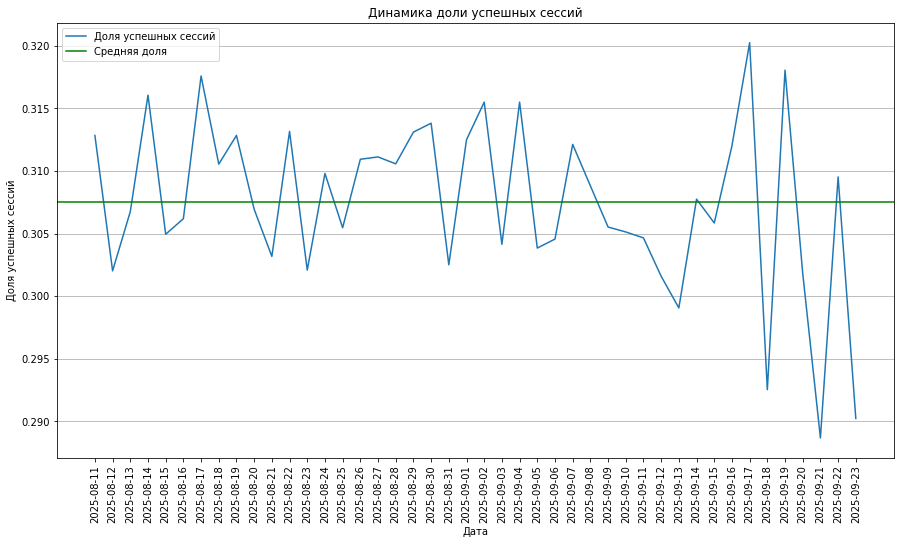

0.3075441043954679

In [13]:
plt.figure(figsize=(15, 8))

plt.plot(good_session_gp['session_date'], good_session_gp['good_session_share'], label ='Доля успешных сессий')

plt.xlabel("Дата")
plt.xticks(rotation=90)

mean_good_value = good_session_gp['good_session_share'].mean()
plt.axhline(y=mean_good_value, color='g', label='Средняя доля')

plt.ylabel("Доля успешных сессий")
plt.legend()
plt.grid(axis='y')
plt.title('Динамика доли успешных сессий')

plt.show()

display(mean_good_value)

- В основном процент успешных сессий находится в промежутке от 30% до 32%;
- В конце наблюдаемого периода данные становятся более волатильны;
- В среднем доля успешных сессий составила 30,7%.

### 2. Подготовка к тесту


#### 2.1. Расчёт размера выборки
Параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Минимальный детектируемый эффект — 3%.

При расчёте размера выборки используем метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.


In [14]:
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1 - beta # Мощность теста
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста


In [15]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = ceil(session_date_gp['user_id'].mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2 / avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9908 пользователей в день составит 4 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

- Сохраним в датафрейме `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем процентную разницу в количестве пользователей в группах A и B.


In [16]:
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')
sessions_test_part.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [17]:
A_id_count = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id'].nunique()
B_id_count = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id'].nunique()
count_differ = round(100 * abs(A_id_count - B_id_count)/ A_id_count, 2)

print(f"Размер выборки A: {A_id_count}")
print(f"Размер выборки B: {B_id_count}")
print(f"Разница между размером выборок составляет: {count_differ} %")

Размер выборки A: 1477
Размер выборки B: 1466
Разница между размером выборок составляет: 0.74 %


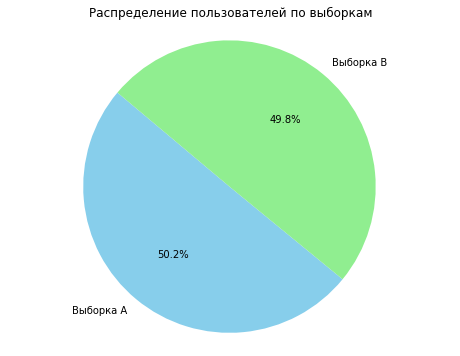

In [18]:
labels = ['Выборка A', 'Выборка B']
sizes = [A_id_count, B_id_count]
colors = ['skyblue', 'lightgreen']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Распределение пользователей по выборкам')
plt.show()

За первый день эксперимента в выборки попало практически одинаковое количество человек

#### 3.2. Проверка пересечений пользователей

- Проверим количество пользователей, которые встречаются одновременно в группах A и B.

In [19]:
A = sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']
B = sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']

intersection = list(set(A) & set(B))
display(intersection)

[]

Пользователи из одной выборки не попадают в другую выборку.

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройства и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.



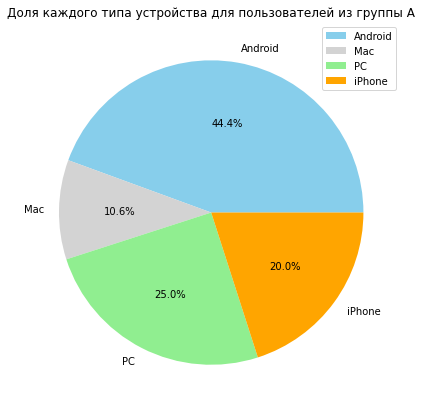

In [20]:
sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('device')['user_id'].nunique().plot(kind='pie',                    
title='Доля каждого типа устройства для пользователей из группы A',
legend=True,
ylabel='',                                                                                                        
autopct='%1.1f%%',
colors = ['skyblue', 'lightgrey', 'lightgreen', 'orange', 'lightgreen'],                                                                                                        
figsize = (10, 7))

plt.show()

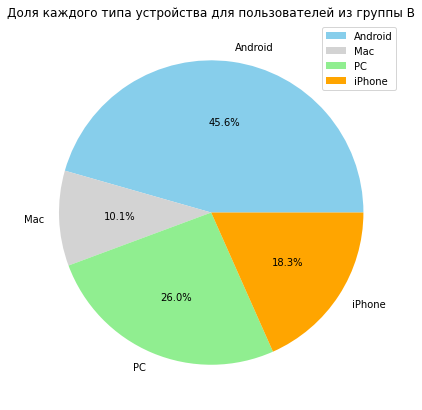

In [21]:
sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('device')['user_id'].nunique().plot(kind='pie',                    
title='Доля каждого типа устройства для пользователей из группы B',
legend=True,
ylabel='',                                                                                                        
autopct='%1.1f%%',
colors = ['skyblue', 'lightgrey', 'lightgreen', 'orange', 'lightgreen'],                                                                                                        
figsize = (10, 7))

plt.show()

Распределения по типам устройств похожи для получившихся выборок.

#### 3.4. Равномерность распределения пользователей по регионам
Убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.


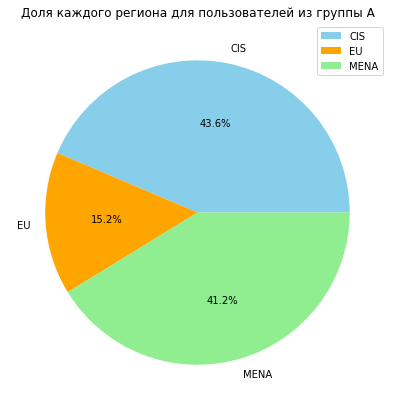

In [22]:
sessions_test_part[sessions_test_part['test_group'] == 'A'].groupby('region')['user_id'].nunique().plot(kind='pie',                    
title='Доля каждого региона для пользователей из группы A',
legend=True,
ylabel='',                                                                                                        
autopct='%1.1f%%',
colors = ['skyblue', 'orange', 'lightgreen'],                                                                                                        
figsize = (10, 7))

plt.show()

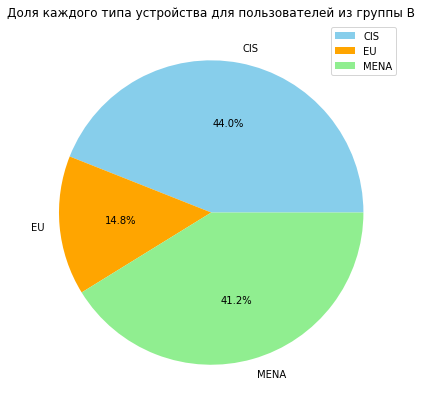

In [23]:
sessions_test_part[sessions_test_part['test_group'] == 'B'].groupby('region')['user_id'].nunique().plot(kind='pie',                    
title='Доля каждого типа устройства для пользователей из группы B',
legend=True,
ylabel='',                                                                                                        
autopct='%1.1f%%',
colors = ['skyblue', 'orange', 'lightgreen'],                                                                                                        
figsize = (10, 7))

plt.show()

Распределение по регионам также совпадает между выборками.

#### 3.5. Вывод после проверки A/B-теста



**После первого дня эксперимента можно сделать следующие выводы:**
1. Количество пользователей в группах различается лишь на **0.7%**. Выборка в группе **А** составила **1477** пользователей, а в группе **В** - **1466** пользователей;
2. Выборки являются независимыми и не содержат одинаковых пользователей;
3. Выборки распределены довольно равномерно. В обеих группах около **45%** пользователей используют **Android**.Также в обеих группах **43.8%** пользователей сосредаточились в регионе **CIS** и **41.2%** - в регионе **MENA**.

Таким образом эксперимент проходит корректно.

### 4. Проверка результатов A/B-теста


#### 4.1. Получение результатов теста и подсчёт основной метрики


In [24]:
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')
sessions_test['good_session']= 0
sessions_test.loc[sessions_test['page_counter'] > 3, 'good_session'] = 1
sessions_test.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, убедимся, что тест проведён корректно и сравниваются две сопоставимые группы.

- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.



- H₀ (нулевая гипотеза) — количество уникальных дневных сессий не различается между тестовой и контрольной группами.
- H₁ (альтернативная гипотеза) — количество уникальных дневных сессий различается между тестовой и контрольной группами.


In [25]:
count_test_A = sessions_test[sessions_test['test_group']== 'A'].groupby('session_date')['session_id'].nunique().reset_index()
count_test_B = sessions_test[sessions_test['test_group']== 'B'].groupby('session_date')['session_id'].nunique().reset_index()

In [26]:
from scipy.stats import ttest_ind

In [27]:
#Проведем t-test, в котором нулевая гипотеза звучит так: Среднее количество ежедневных сессий в двух выборках не различается
test_result, test_result_pvalue = ttest_ind(
count_test_A['session_id'],
count_test_B['session_id'],
alternative='two-sided') # в альтернативной гипотезе проверим различие среднего в обе стороны

alpha = 0.05

if test_result_pvalue > alpha:
    print(f'pvalue={test_result_pvalue} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'pvalue={test_result_pvalue} < {alpha}')
    print('Отвергаем нулевую гипотезу')

pvalue=0.938219304859116 > 0.05
Не получилось отвергнуть нулевую гипотезу


Тест не смог опровергнуть нулевую гипотезу, значит у нас нет оснований полагать, что среднее количество сессий в выборках различается.

#### 4.3. Сравнение доли успешных сессий



In [28]:
good_session_test_A = sessions_test[sessions_test['test_group']== 'A']
good_session_test_B = sessions_test[sessions_test['test_group']== 'B']

In [29]:
good_session_A = round(good_session_test_A['good_session'].sum() / good_session_test_A.shape[0], 2)
    
good_session_B = round(good_session_test_B['good_session'].sum() / good_session_test_B.shape[0], 2)
    
share_diff = round(abs(good_session_A - good_session_B), 2)

print(f"Доля успешных сессий в выборке А: {good_session_A} %")
print(f"Доля успешных сессий в выборке B: {good_session_B} %")
print(f"Разница между показателями составляет {share_diff} %")

Доля успешных сессий в выборке А: 0.31 %
Доля успешных сессий в выборке B: 0.32 %
Разница между показателями составляет 0.01 %


#### 4.4. Проверим статистическую значимость изменения ключевой метрики


In [30]:
from statsmodels.stats.proportion import proportions_ztest

In [31]:
n_a, n_b = good_session_test_A.shape[0], good_session_test_B.shape[0] #размеры выборок

m_a, m_b = good_session_test_A['good_session'].sum(), good_session_test_B['good_session'].sum() # количество успехов

alpha = 0.05

# Используем Z-тест пропорций, так как исследуем доли
stat_ztest, p_value_ztest = proportions_ztest(
[m_a, m_b],
[n_a, n_b],
alternative='smaller' # проверяем что доля в выборке А меньше доли в выборке В
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Отвергаем нулевую гипотезу')

pvalue=0.0001574739988036123 < 0.05
Отвергаем нулевую гипотезу


Так как **pvalue оказалось меньше уровня значимости**, мы **отвергаем нулевую гипотезу** и можем считать положительное **изменение доли** успешных сессий в выборке B **статистически значимым**.

In [32]:
#Рассчитаем длительность эксперимента
all_test = good_session_test_A.shape[0] + good_session_test_B.shape[0]
print(f"Размер группы A составил {good_session_test_A.shape[0]} наблюдений;")
print(f"Размер группы B составил {good_session_test_B.shape[0]} наблюдений;")
print(f"Размер общей выборки эксперимента составил {all_test} наблюдений;")
print(f"При среднем трафике в 9908 наблюдений в день эксперимент продлился {ceil(all_test/9908)} дней.")

Размер группы A составил 49551 наблюдений;
Размер группы B составил 50454 наблюдений;
Размер общей выборки эксперимента составил 100005 наблюдений;
При среднем трафике в 9908 наблюдений в день эксперимент продлился 11 дней.


#### 4.5. Вывод по результатам A/B-эксперимента


### Результаты эксперимента:
В результате данной работы был проведен эксперимент, который заключался в анализе влияния нового алгоритма рекомендаций на вовлеченность пользователей в приложение.

Эксперимент предполагал сбор двух выборок: **контрольная группа А с 49 551 наблюдением**, **тестовая группа  В** с новым алгоритмом рекомендаций с **50 454 наблюдениями**. Выборки получились сопоставимыми и независимыми.

Общий размер выборки составил **100 005 наблюдений**, эксперимент продолжался предположительно **11 дней**.

Были проведены 2 теста: **t-тест** и **Z-тест пропорций**.

Ключевые выводы эксперимента:
- **Среднее количество сессий** в двух группах **не изменилось**, p-value = 0.9, оказался больше уровня значимости в 5%;
- **Доля успешных сессий** в тестовой выборке **увеличилась**, p-value = 0.00016, оказался меньше уровня значимости в 5%;
- Нововведение не увеличило среднее количество сессий пользователелей приложения, однако положительно повлияло на вовлеченность пользователей в текущих сессиях, увеличив долю сессий с не менее 4 просмотренными страницами. Таким образом на основе полученных результатов можно одобрить предложение по введению нового алгоритма в приложение.